# 1. Importing libraries

In [3]:
import pandas as pd
import numpy as np

import fastf1
from fastf1.ergast import Ergast

from tqdm import tqdm
import os

import sys
sys.path.append('../')

from src.race_prediction_model.extract import *
from src.race_prediction_model.feature_engineering import add_features_to_results

In [4]:
# Data processing  
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import pickle

# Pandas options  
# -----------------------------------------------------------------------
pd.options.display.max_colwidth = None

# Path configuration for custom module imports  
# -----------------------------------------------------------------------
import sys  
sys.path.append('../')  # Adds the parent directory to the path for custom module imports  

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings  
warnings.filterwarnings("ignore") 

# Machine learning imports
# -----------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler

# Custom functions and classes
# -----------------------------------------------------------------------
from src.preprocess import *
from src.classification import *

# 2. Data loading

In [5]:
df = pd.read_csv('../data/output/featured_results.csv', index_col=0)

In [6]:
df

,DriverId,TeamId,Position,GridPosition,Time,Status,Points,season,round,circuitId,DriverPointsCumulative,TeamPointsCumulative,Winner,Podium,WinsCumulative,PodiumsCumulative,MeanPreviousGrid,MeanPreviousPosition
8,alonso,ferrari,1.0,3.0,0.000,Finished,25.0,2010,1,bahrain,25.0,25.0,1,1,1,1,3.000000,1.000000
7,massa,ferrari,2.0,2.0,16.099,Finished,18.0,2010,1,bahrain,18.0,43.0,0,1,0,1,2.000000,2.000000
2,hamilton,mclaren,3.0,4.0,23.182,Finished,15.0,2010,1,bahrain,15.0,15.0,0,1,0,1,4.000000,3.000000
5,vettel,red_bull,4.0,1.0,38.799,Finished,12.0,2010,1,bahrain,12.0,12.0,0,0,0,0,1.000000,4.000000
4,rosberg,mercedes,5.0,5.0,40.213,Finished,10.0,2010,1,bahrain,10.0,10.0,0,0,0,0,5.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,sargeant,williams,16.0,20.0,87.791,Finished,0.0,2023,22,yas_marina,1.0,26.0,0,0,0,0,15.000000,14.333333
24,zhou,alfa,17.0,19.0,89.422,Finished,0.0,2023,22,yas_marina,6.0,16.0,0,0,0,0,18.666667,16.333333
55,sainz,ferrari,18.0,16.0,189.422,Retired,0.0,2023,22,yas_marina,178.0,363.0,0,0,1,3,11.666667,10.000000
77,bottas,alfa,19.0,18.0,189.422,+1 Lap,0.0,2023,22,yas_marina,10.0,16.0,0,0,0,0,14.333333,17.333333


# 3. Preprocess

### Column Analysis

| Column                   | Data Type   | Observations                                                                |
|--------------------------|-------------|-----------------------------------------------------------------------------|
| `DriverId`               | `object`    | Categorical, requires encoding.                                             |
| `TeamId`                 | `object`    | Categorical, requires encoding.                                             |
| `Position`               | `float64`   | Continuous, represents positions; requires scaling.                         |
| `GridPosition`           | `float64`   | Continuous, requires scaling.                                               |
| `Time`                   | `float64`   | Continuous, represents time; requires scaling.                              |
| `Status`                 | `object`    | Categorical, requires encoding.                                             |
| `Points`                 | `float64`   | Continuous, represents scores; requires scaling.                            |
| `season`                 | `int64`     | Discrete numeric, requires encoding or scaling depending on its role.       |
| `round`                  | `int64`     | Discrete numeric, represents ordinal data; requires ordinal encoding.       |
| `circuitId`              | `object`    | Categorical, requires encoding.                                             |
| `DriverPointsCumulative` | `float64`   | Continuous, represents cumulative data; requires scaling.                   |
| `TeamPointsCumulative`   | `float64`   | Continuous, represents cumulative data; requires scaling.                   |
| `Winner`                 | `int64`     | Binary, already encoded as 0/1.                                             |
| `Podium`                 | `int64`     | Binary, already encoded as 0/1.                                             |
| `WinsCumulative`         | `int64`     | Discrete numeric, requires scaling.                                         |
| `PodiumsCumulative`      | `int64`     | Discrete numeric, requires scaling.                                         |
| `MeanPreviousGrid`       | `float64`   | Continuous, requires scaling.                                               |
| `MeanPreviousPosition`   | `float64`   | Continuous, requires scaling.                                               |



### Encoding Strategy

1. **Nominal Categorical Variables**:
   - `DriverId`, `TeamId`, `Status`, and `circuitId` are unordered categorical variables.

   - **One-Hot Encoding** is suitable for `DriverId` and `TeamId` if the number of unique values is limited. Otherwise, **Target Encoding** can be used.

   - For `Status` and `circuitId`, due to potentially many levels, **Target Encoding** is preferred.

2. **Ordinal Categorical Variables**:
   - `round` represents ordered values and should use **Ordinal Encoding**.
   
   - Ensure that the order aligns with the natural numerical order of the rounds.

3. **Binary Variables**:
   - `Winner` and `Podium` are already binary and require no further transformation.

### Scaling Strategy

1. **Continuous Variables**:
   - `Position`, `GridPosition`, `Time`, `Points`, `DriverPointsCumulative`, `TeamPointsCumulative`, `WinsCumulative`, `PodiumsCumulative`, `MeanPreviousGrid`, and `MeanPreviousPosition` require scaling.

   - Depending on the presence of outliers:
     - Use **Standard Scaling** for normally distributed data.
     
     - Use **Min-Max Scaling** if the data has no significant outliers and needs normalization within a specific range.

2. **Discrete Variables**:
   - `season` and `round` may be scaled or encoded depending on their role in modeling. If used as categorical features, encode them; if treated as continuous, scale them.

Como queremos predecir si un piloto va a ganar una carrera, necesitamos eliminar las columnas que contengan información sobre el resultado de la carrera, ya que no podemos proporcionar como input un dato de algo que todavía no ha ocurrido.

Nuestra target variable es en este caso `Winner` (podría ser `Podium` si queremos predecir si va a quedar en el podio, `Position` si queremos predecir la posición exacta, etc)

De esta forma podemos eliminar `Position`, `Time`, `Status`, `Points`, `Podium`. El resto de variables sí las podemos conocer antes de disputarse la carrera.

In [7]:
df.drop(columns=['Position', 'Time', 'Status', 'Points', 'Podium'], inplace=True)

In [8]:
df.isna().sum()

DriverId                  0
TeamId                    0
GridPosition              3
season                    0
round                     0
circuitId                 0
DriverPointsCumulative    0
TeamPointsCumulative      0
Winner                    0
WinsCumulative            0
PodiumsCumulative         0
MeanPreviousGrid          0
MeanPreviousPosition      0
dtype: int64

En este caso tenemos 3 nulos en la parrilla de salida. Veamos de qué son.

In [9]:
df[df['GridPosition'].isna()]

,DriverId,TeamId,GridPosition,season,round,circuitId,DriverPointsCumulative,TeamPointsCumulative,Winner,WinsCumulative,PodiumsCumulative,MeanPreviousGrid,MeanPreviousPosition
9,mazepin,haas,NaN,2021,22,yas_marina,0.0,0.0,0,0,0,20.0,18.0
47,mick_schumacher,haas,NaN,2022,2,jeddah,0.0,12.0,0,0,0,15.5,12.5
18,stroll,aston_martin,NaN,2023,15,marina_bay,41.0,204.0,0,0,0,15.5,13.5


Estos registros corresponden a pilotos que no llegaron a salir (DNS), por lo que directamente los eliminamos

In [10]:
df.dropna(inplace=True)

In [11]:
df.select_dtypes(include='O').columns

Index(['DriverId', 'TeamId', 'circuitId'], dtype='object')

In [12]:
encoding_methods = {"onehot": ['TeamId'],
                    "target": ['DriverId'],
                    "ordinal" : {
                        'circuitId': df['circuitId'].unique().tolist()
                        },
                    "frequency": []
                    }

encoder = Encoding(df, encoding_methods, 'Winner')

In [13]:
df_encoded = encoder.execute_all_encodings()

Scaling

In [14]:
df_scaled = scale_df(df_encoded, df_encoded.columns.to_list(), method="robust", include_others=False)

# 4. Model selection

Estamos evaluendo un modelo que predice si un piloto ganará una carrera. En este caso queremos minimizar el número de errores en general, ya que es igual de malo predecir que un piloto va a ganar y equivocarnos que predecir que no lo va a hacer y sí lo haga.

Por lo tanto, trataremos mazimizar la métrica `f1_score` lo máximo posible ya que es un compromiso entre `precision`y `recall`.

In [15]:
models = ClassificationModels(df_scaled, 'Winner')

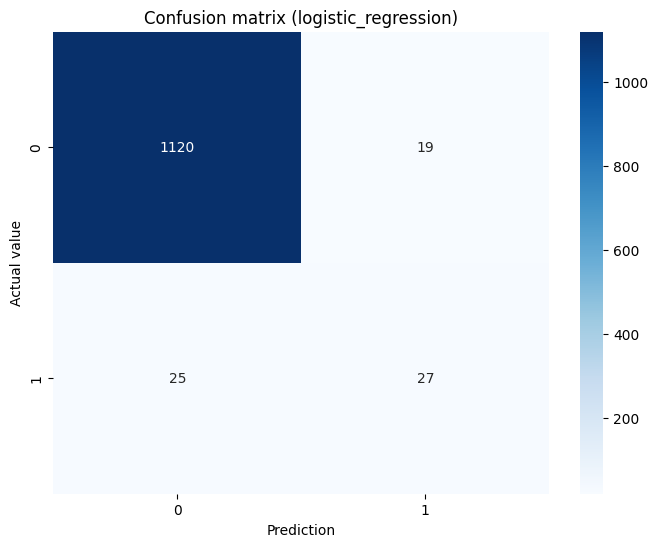

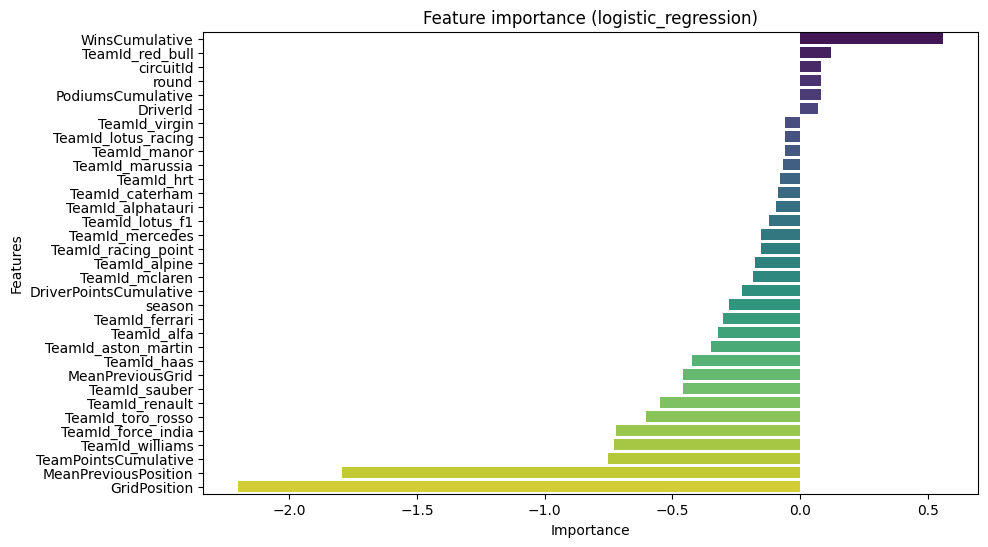

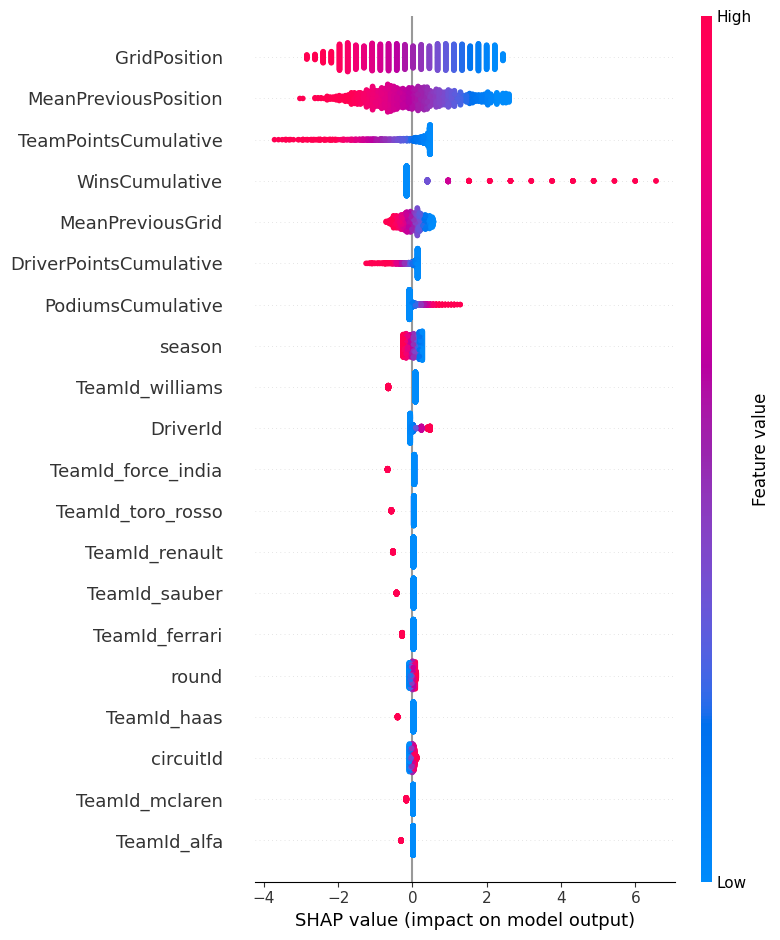

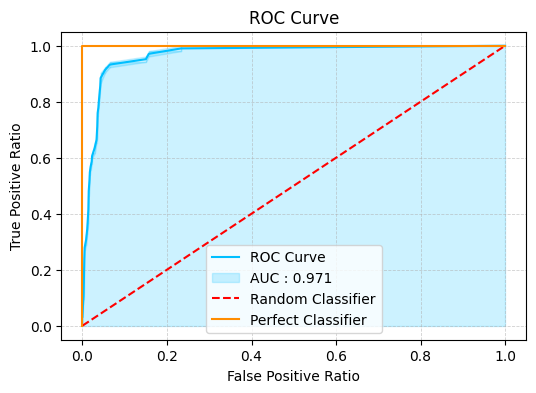

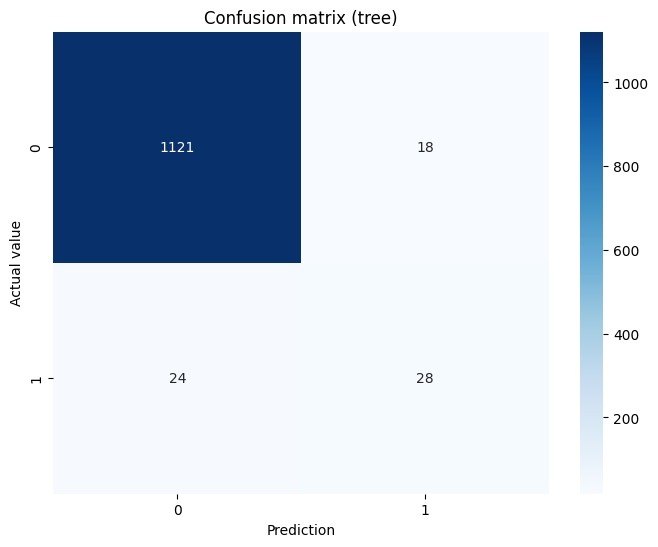

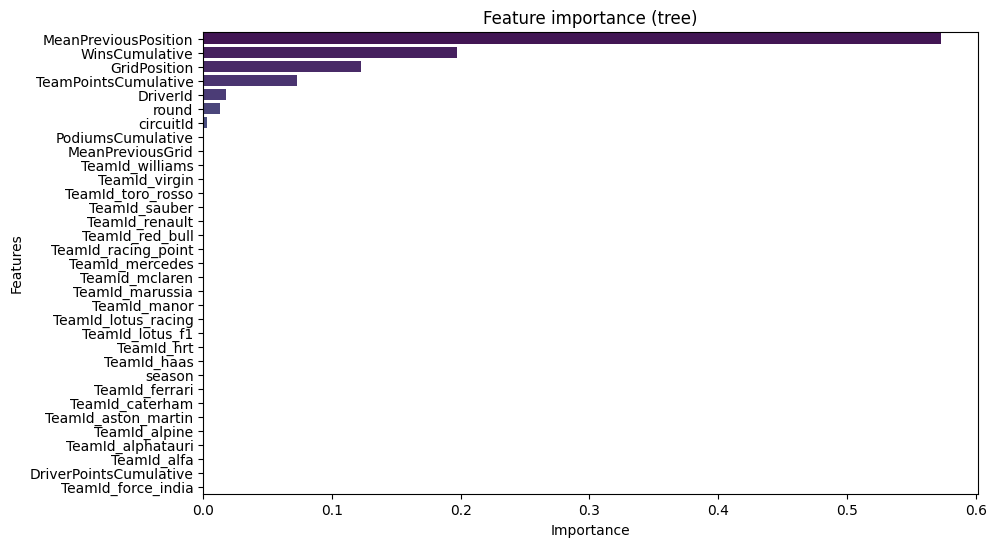

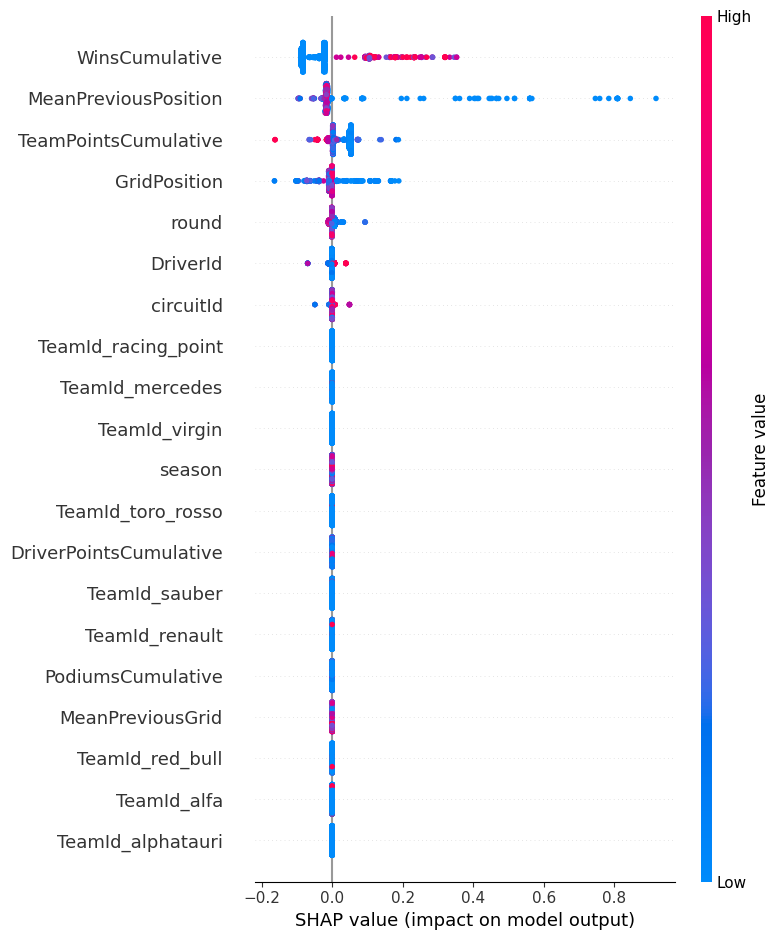

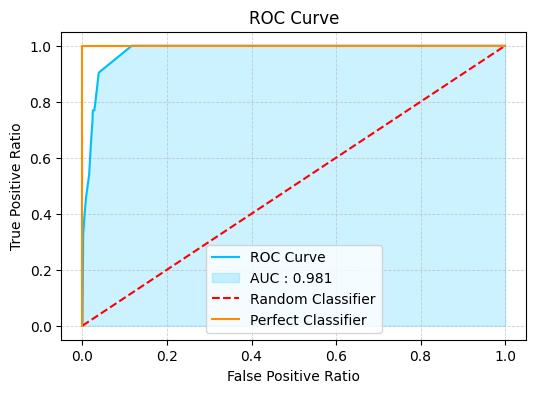

In [16]:
# model_list = ["logistic_regression", "tree", "random_forest", "gradient_boosting", "xgboost"]
model_list = ["logistic_regression", "tree"]

df_results = pd.DataFrame()

for model in model_list:

    models.fit_model(model, file_name=model)
    models.plot_confusion_matrix(model)
    models.plot_predictors_importance(model)
    models.plot_shap_summary(model)
    df_current_results = models.get_metrics(model)
    df_current_results["model"] = model
    df_results = pd.concat([df_results, df_current_results], axis = 0)
    models.plot_roc_curve(model)

In [17]:
df_results

,accuracy,precision,recall,f1,kappa,auc,time_seconds,cores,model
train,0.966828,0.962957,0.966828,0.963666,0.569820,0.973643,42.481989,NaN,logistic_regression
test,0.963056,0.961085,0.963056,0.961974,0.531831,0.970993,42.481989,NaN,logistic_regression
train,0.973336,0.971215,0.973336,0.971669,0.672745,0.984180,0.735299,11.0,tree
test,0.964736,0.962870,0.964736,0.963702,0.553112,0.981445,0.735299,11.0,tree


---